<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/%EA%B3%BC%EC%A0%9C2_TF_hub_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텐서플로 허브와 전이학습

* https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=ko
* 위 주소에 들어가서 전이학습을 연습합니다.
* Run in Google Colab 을 이용하여 진행합니다.
* 과제는 전반적인 코드리뷰 입니다.

## 설치하기

In [160]:
import matplotlib.pylab as plt
import tensorflow as tf
!pip install -U tf-hub-nightly
import tensorflow_hub as hub
from tensorflow.keras import layers

## ImageNet 분류하기

### 분류기 다운로드하기

In [161]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [162]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))])

### 싱글 이미지 실행시키기

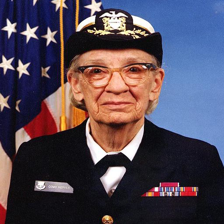

In [163]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [164]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

차원 배치를 추가하세요, 그리고 이미지를 모델에 통과시키세요.

In [165]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

그 결과는 로지트의 1001 요소 벡터입니다. 이는 이미지에 대한 각각의 클래스 확률을 계산합니다.

그래서 탑 클래스인 ID는 최대값을 알 수 있습니다:

In [166]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### 예측 해독하기

In [167]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

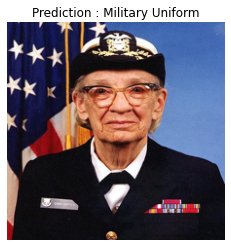

In [168]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction : " + predicted_class_name.title())

## 간단한 전이 학습

텐서플로 허브를 사용함으로써, 우리의 데이터셋에 있는 클래스들을 인지하기 위해 모델의 최상위 층을 재학습 시키는 것이 쉬워졌습니다.

### 데이터셋

 이 예제를 해결하기 위해, 텐서플로의 flowers 데이터셋을 사용할 것입니다:

In [169]:
data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)

In [170]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

우리의 모델에 이 데이터를 가장 간단하게 로딩 하는 방법은 `tf.keras.preprocessing.image.image.ImageDataGenerator`를 사용하는 것이고,

모든 텐서플로 허브의 이미지 모듈들은 0과 1사이의 상수들의 입력을 기대합니다. 이를 만족 시키기 위해 `ImageDataGenerator`의 `rescale`인자를 사용하세요.

그 이미지의 사이즈는 나중에 다뤄질 것입니다.

In [171]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1 / 255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


결과로 나온 오브젝트는 `image_batch`와 `label_batch`를 같이 리턴 하는 반복자입니다.

In [172]:
for image_batch, label_batch in image_data:
  print("Image batch shape", image_batch.shape)
  print("Label batch shape", label_batch.shape)
  break

Image batch shape (32, 224, 224, 3)
Label batch shape (32, 5)


### 이미지 배치에 대한 분류기를 실행해보자

In [173]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [174]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'broom', 'daisy', 'fountain', 'rapeseed', 'daisy', 'fig',
       'daisy', 'spider web', 'picket fence', 'porcupine', 'sea urchin',
       'tub', 'tarantula', 'daisy', 'daisy', 'picket fence', 'daisy',
       'hamper', 'daisy', 'paintbrush', 'hip', 'pot',
       'Bedlington terrier', 'daisy', 'daisy', 'daisy', "jack-o'-lantern",
       'picket fence', 'spider web', 'bubble', 'conch'], dtype='<U30')

얼마나 많은 예측들이 이미지에 맞는지 검토해봅시다:

---



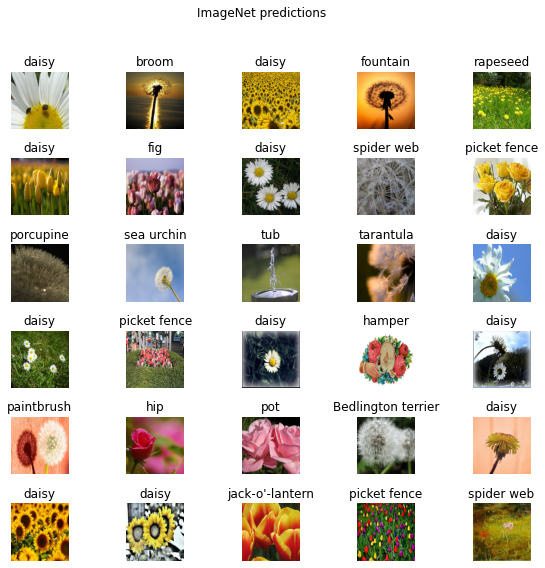

In [175]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

이미지 속성을 가진 `LICENSE.txt` 파일을 보세요.

결과가 완벽과는 거리가 멀지만, 모델이 ("daisy"를 제외한) 모든 것을 대비해서 학습된 클래스가 아니라는 것을 고려하면 합리적입니다.

### 헤드리스 모델을 다운로드하세요

텐서플로 허브는 맨 위 분류층이 없어도 모델을 분배 시킬 수 있습니다. 이는 전이 학습을 쉽게 할 수 있게 만들었습니다.

fthub.dev의 [텐서플로 2.0버전의 양립 가능한 이미지 특성 벡터 URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) 은 모두 이 곳에서 작동할 것입니다.

In [176]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

특성 추출기를 만들어봅시다.

In [177]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

이 것은 각각의 이미지마다 길이가 1280인 벡터가 반환됩니다:

In [178]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


특성 추출기 계층에 있는 변수들을 굳히면, 학습은 오직 새로운 분류 계층만 변경시킬 수 있습니다.

In [179]:
feature_extractor_layer.trainable = False

### 분류 head를 붙이세요.

이제 `tf.keras.Sequential` 모델에 있는 허브 계층을 포장하고, 새로운 분류 계층을 추가하세요.

In [180]:
model = tf.keras.Sequential([feature_extractor_layer, layers.Dense(image_data.num_classes, activation='softmax')])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [181]:
predictions = model(image_batch)

In [182]:
predictions.shape

TensorShape([32, 5])

### 모델을 학습시키세요

학습 과정 환경을 설정하기 위해 컴파일을 사용하세요:

In [183]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics=['acc'])

이제 모델을 학습시키기 위해 `.fit`방법을 사용하세요.

예제를 짧게 유지시키기 위해 오로지 2세대만 학습시키세요. 학습 과정을 시각화하기 위해서, 맞춤형 회신을 사용하면 손실과, 세대 평균이 아닌 배치 개별의 정확도를 기록할 수 있습니다.

In [184]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [185]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch = steps_per_epoch,
                              callbacks = [batch_stats_callback])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
115/115 [==============================] - 104s 876ms/step - loss: 0.5526 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 102s 885ms/step - loss: 0.3234 - acc: 0.8125


지금부터, 단순한 학습 반복이지만, 우리는 항상 모델이 프로세스를 만드는 중이라는 것을 알 수 있습니다.

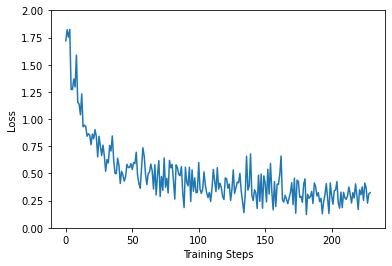

In [186]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

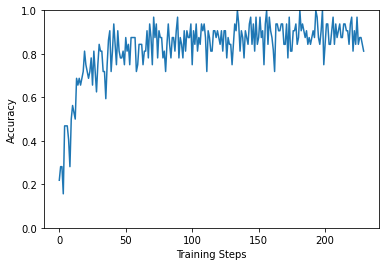

In [187]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### 예측을 확인하세요

이 전의 계획을 다시하기 위해서, 클래스 이름들의 정렬된 리스트를 첫번째로 얻으세요:

In [188]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

모델을 통해 이미지 배치를 실행시키세요. 그리고 인덱스들을 클래스 이름으로 바꾸세요.

In [189]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

결과를 계획하세요

In [190]:
label_id = np.argmax(label_batch, axis=-1)

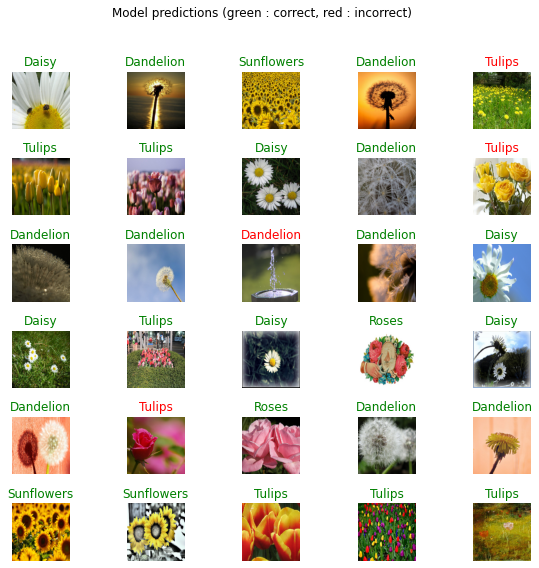

In [191]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green : correct, red : incorrect)")


## 당신의 모델을 내보내세요

당신은 모델을 학습시켜왔기 때문에, 저장된 모델을 내보내세요:

In [192]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1635408207/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1635408207/assets


'/tmp/saved_models/1635408207'

이제 우리는 그것을 새롭게 로딩 할 수 있고, 이는 같은 결과를 줄 것입니다:

In [193]:
reloaded = tf.keras.models.load_model(export_path)

In [194]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [195]:
abs(reloaded_result_batch - result_batch).max()

0.0

저장된 모델은 추후에 추론을 할 수도 있고, [TFLite](https://www.tensorflow.org/lite/convert/) 나 [TFjs](https://github.com/tensorflow/tfjs-converter) 로 변환할 수 있습니다.
